##1-İMPORTİNG LİBRARİES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
# Grafiklerini göstereceğimiz fonksiyon
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend fonksiyonu
def trend(time, slope=0): # slope = Eğim
    return slope * time
  

# MEvsimselliği gösterebileceğimiz fonksiyon >>> Mevsimsel grafiğin 0.4 ü cos fonksiyonu 0.6 sı euler sabiti
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Gürültü fonksiyonu 
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level





In [ ]:
#datasetimizi oluşturalım
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

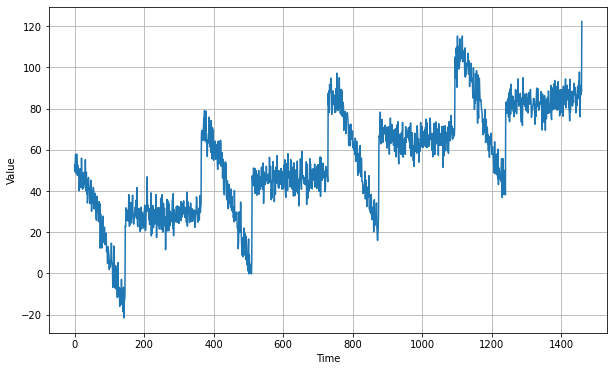

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN ForeCasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
8/8 [==============================] - 3s 97ms/step - loss: 50.9985 - mae: 51.4965 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 84ms/step - loss: 38.9833 - mae: 39.4809 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 56ms/step - loss: 35.9195 - mae: 36.4166 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 56ms/step - loss: 30.5252 - mae: 31.0220 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 58ms/step - loss: 25.4010 - mae: 25.8954 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 68ms/step - loss: 20.5743 - mae: 21.0674 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 58ms/step - loss: 16.4669 - mae: 16.9508 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 54ms/step - loss: 14.6656 - mae: 15.1511 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 14.1008 - mae: 14.5842 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

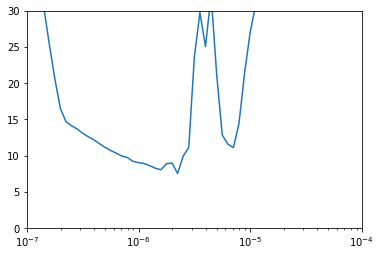

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Datasetlerimizi oluşturalım
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

#modelimizi yaratalım
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

#Gradient İniş için optimizer ayarlayalım.Grafiğe göre en uygun 1.5e-6 (yaklaşık)
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)

# modeli compile(derleme) edelim
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Patlama yapmadan önce epoch durdurmak için earlystopping çağıralım(50 epoch da azalma durursa durdurmayı çağır)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# Doğrulama seti her iyileştiğinde kaydolması için bir callback çağırıyoruz

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Şimdi modeli eğitelim
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])




Epoch 1/500
      7/Unknown - 2s 28ms/step - loss: 13935.6191 - mae: 13936.1191

8/8 [==============================] - 6s 593ms/step - loss: 14034.6318 - mae: 14035.1318 - val_loss: 15692.7891 - val_mae: 15693.2891
Epoch 2/500
8/8 [==============================] - 1s 53ms/step - loss: 20525.3477 - mae: 20525.8496 - val_loss: 29067.3223 - val_mae: 29067.8223
Epoch 3/500
8/8 [==============================] - 1s 51ms/step - loss: 20126.7266 - mae: 20127.2266 - val_loss: 35534.3398 - val_mae: 35534.8398
Epoch 4/500
8/8 [==============================] - 0s 46ms/step - loss: 19948.3926 - mae: 19948.8906 - val_loss: 35961.1875 - val_mae: 35961.6836
Epoch 5/500
8/8 [==============================] - 0s 46ms/step - loss: 20572.7305 - mae: 20573.2285 - val_loss: 30027.0664 - val_mae: 30027.5684
Epoch 6/500
8/8 [==============================] - 0s 49ms/step - loss: 20637.8633 - mae: 20638.3652 - val_loss: 26889.9961 - val_mae: 26890.4941
Epoch 7/500
8/8 [==============================] - 1s 50ms/step - loss: 20612.2051 - mae: 20612.7051 - val_loss: 26195.4551 - val_mae: 

In [ ]:
model = keras.models.load_model("my_checkpoint")

In [ ]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 15ms/step


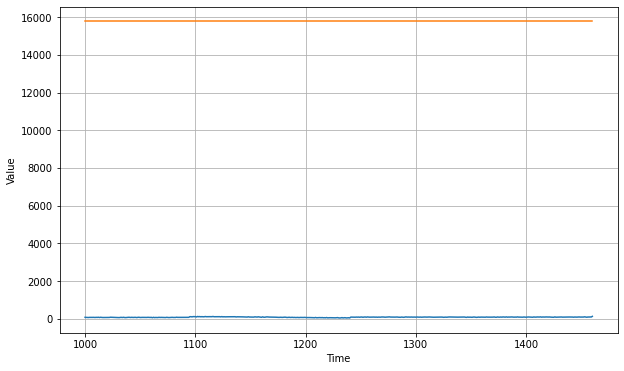

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Sequence-to-sequence

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15694.1045

In [ ]:
def seq2seq_window_dataset(series,window_size,batch_size = 32,shuffle_buffer = 1000):
  series = tf.expand_dims(series , axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size +1,shift = 1,drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size + 1 ))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)


In [ ]:
for X_batch,Y_batch in seq2seq_window_dataset(tf.range(10),3,batch_size = 1):
  print("X  " , X_batch.numpy())
  print("Y", Y_batch.numpy())

X   [[[4]
  [5]
  [6]]]
Y [[[5]
  [6]
  [7]]]
X   [[[1]
  [2]
  [3]]]
Y [[[2]
  [3]
  [4]]]
X   [[[0]
  [1]
  [2]]]
Y [[[1]
  [2]
  [3]]]
X   [[[5]
  [6]
  [7]]]
Y [[[6]
  [7]
  [8]]]
X   [[[2]
  [3]
  [4]]]
Y [[[3]
  [4]
  [5]]]
X   [[[6]
  [7]
  [8]]]
Y [[[7]
  [8]
  [9]]]
X   [[[3]
  [4]
  [5]]]
Y [[[4]
  [5]
  [6]]]


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size = 128)


#model kur
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape = [None,1]),
    keras.layers.SimpleRNN(100,return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x : x *200.0)
])

# iniş için deneme callback 
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-7*100**(epoch /30)
)

# optimizer 
optimizer = keras.optimizers.SGD(1e-7,momentum = 0.9)

# compile 
model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

history = model.fit(train_set,epochs = 100,callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 34ms/step - loss: 29.2868 - mae: 29.7826 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 26.1611 - mae: 26.6566 - lr: 1.1659e-07
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 25.1131 - mae: 25.6089 - lr: 1.3594e-07
Epoch 4/100
8/8 [==============================] - 1s 47ms/step - loss: 23.2339 - mae: 23.7275 - lr: 1.5849e-07
Epoch 5/100
8/8 [==============================] - 1s 45ms/step - loss: 21.4408 - mae: 21.9346 - lr: 1.8478e-07
Epoch 6/100
8/8 [==============================] - 1s 65ms/step - loss: 19.4592 - mae: 19.9526 - lr: 2.1544e-07
Epoch 7/100
8/8 [==============================] - 1s 44ms/step - loss: 17.6169 - mae: 18.1060 - lr: 2.5119e-07
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 16.2252 - mae: 16.7128 - lr: 2.9286e-07
Epoch 9/100
8/8 [==============================] - 1s 43ms/step - loss: 15.3794 - mae: 15.8639 - lr: 3.4

(1e-07, 0.0001, 0.0, 30.0)

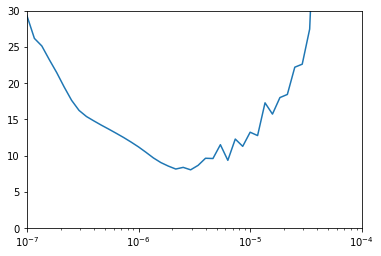

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size=30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid,window_size,batch_size = 128)

# create model 
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x : x *200.0)
])

# optimizer 
optimizer = keras.optimizers.SGD(1e-7,momentum = 0.9)

# callback earlystop

earlystopping = keras.callbacks.EarlyStopping(patience = 10)

# compile
model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

# model.fit
model.fit(
    train_set,
    epochs = 500,
    validation_data = valid_set,
    callbacks = [earlystopping]
)



Epoch 1/500
8/8 [==============================] - 3s 104ms/step - loss: 358.3143 - mae: 358.8143 - val_loss: 334.1580 - val_mae: 334.6577
Epoch 2/500
8/8 [==============================] - 0s 47ms/step - loss: 292.3937 - mae: 292.8937 - val_loss: 246.1863 - val_mae: 246.6862
Epoch 3/500
8/8 [==============================] - 1s 54ms/step - loss: 189.8887 - mae: 190.3885 - val_loss: 123.3294 - val_mae: 123.8294
Epoch 4/500
8/8 [==============================] - 1s 53ms/step - loss: 82.8551 - mae: 83.3550 - val_loss: 12.8064 - val_mae: 13.2900
Epoch 5/500
8/8 [==============================] - 0s 48ms/step - loss: 28.6649 - mae: 29.1614 - val_loss: 54.8300 - val_mae: 55.3300
Epoch 6/500
8/8 [==============================] - 1s 53ms/step - loss: 37.5776 - mae: 38.0770 - val_loss: 37.7401 - val_mae: 38.2400
Epoch 7/500
8/8 [==============================] - 1s 73ms/step - loss: 21.2051 - mae: 21.6969 - val_loss: 15.2178 - val_mae: 15.7109
Epoch 8/500
8/8 [==============================] 

In [ ]:
rnn_forecast = model_forecast(model,series[...,np.newaxis],window_size)
rnn_forecast = rnn_forecast[split_time - window_size : -1,-1,0]

45/45 [==============================] - 1s 9ms/step


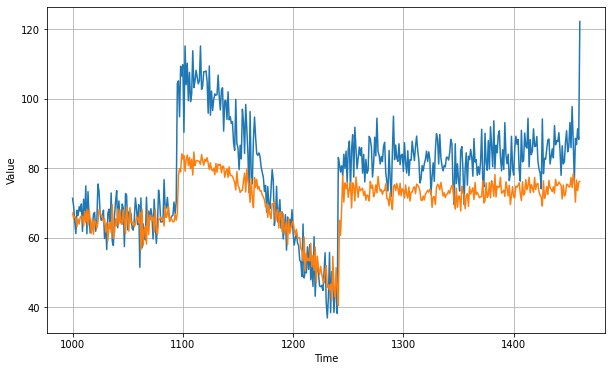

In [ ]:
plt.figure(figsize= (10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

9.824756

#Forecasting with a stateful RNN

---



##SETUP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
def plot_series(time,series,format = "-",start = 0,end = None,label = None):
  plt.plot(time[start:end],series[start : end],label = label)
  plt.xlabel("Time")
  plt.ylabel("Series")
  if label : 
    plt.legend(fontsize = 14)
    
  plt.grid(True)


def trend(time,slope = 0):
  return time * slope 

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

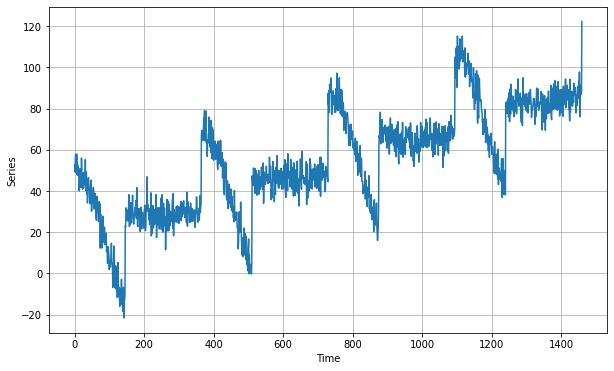

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

##Stateful RNN Forecast

In [ ]:
def sequential_window_dataset(series,window_size):
  series = tf.expand_dims(series,axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size +1 , shift = window_size,drop_remainder=True)
  ds = ds.flat_map(lambda window : window.batch(window_size + 1))
  ds = ds.map(lambda window : (window[:-1],window[1:]))
  return ds.batch(1).prefetch(1)

In [ ]:
for X_batch , Y_batch in sequential_window_dataset(tf.range(10),3):
  print("X",X_batch.numpy(), "Y",Y_batch.numpy())

X [[[0]
  [1]
  [2]]] Y [[[1]
  [2]
  [3]]]
X [[[3]
  [4]
  [5]]] Y [[[4]
  [5]
  [6]]]
X [[[6]
  [7]
  [8]]] Y [[[7]
  [8]
  [9]]]


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size = 30
train_set = sequential_window_dataset(x_train,window_size)

# model create 
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences = True,stateful = True,batch_input_shape =[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x : x *200.0)
])

# gradient inis
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/30))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(lr = 1e-8,momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

history = model.fit(train_set,epochs = 100,callbacks = [lr_schedule,reset_states])

(1e-08, 0.0001, 0.0, 30.0)

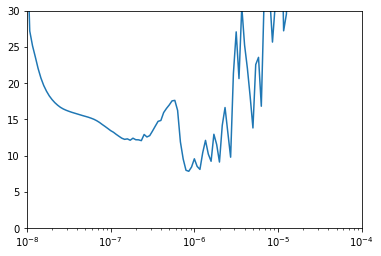

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size =30
train_set = sequential_window_dataset(x_train,window_size)
valid_set = sequential_window_dataset(x_valid,window_size)


#Create model
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape = [1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x : x *200.0)
])

# optimizer 
optimizer = keras.optimizers.SGD(lr = 1e-7,momentum = 0.9)

# eralystopping
early_stopping = keras.callbacks.EarlyStopping(patience = 50)

#model compile
model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

#reset states
reset_states = ResetStatesCallback()
# save model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5",save_best_only = True
)

# model fit
model.fit(
    train_set,epochs = 500,
    validation_data = valid_set,
    callbacks = [early_stopping,reset_states,model_checkpoint]
)

In [ ]:
# load model
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
#predict rnn
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 0s 223ms/step


In [ ]:
rnn_forecast.shape

(461,)

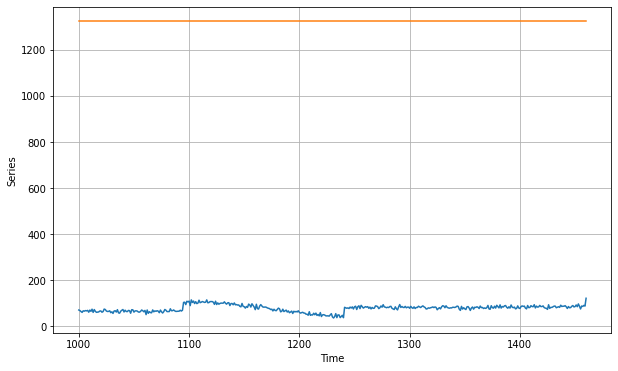

In [ ]:
plt.figure(figsize = (10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1244.4149